# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Tennis - Continous Control MultiAgent

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [8]:
from ddpg_agent3 import ReplayBuffer
from maddpg3 import MADDPG

# initialize policy and critic
lr_actor=1e-3, 
lr_critic=1e-3
maddpg = MADDPG(random_seed=1,tau=1e-1, state_size=24,action_size=2, lr_actor=1e-3, lr_critic=1e-3)

buffer_size = int(1e6)  # replay buffer size
batch_size = 512        # minibatch size
memory = ReplayBuffer(action_size, buffer_size, batch_size, 0)

model_dir= os.getcwd()+"/model_dir"
os.makedirs(model_dir, exist_ok=True)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.05
Episode 500	Average Score: 0.08
Episode 600	Average Score: 0.11
Episode 700	Average Score: 0.47
Episode 703	Average Score: 0.51Average score of 0.5 reached!


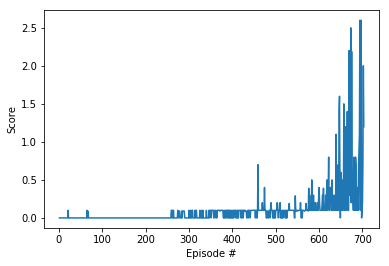

In [9]:
def ddpg(n_episodes=4000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        for t in range(max_t):
            actions = maddpg.act(states)                       # select an action for each agent
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            #add experience to memory
            memory.add(states.reshape(1,-1), actions, rewards, next_states.reshape(1,-1), dones)
            #perform maddpg update
            # update once after every episode_per_update
            if len(memory) > batch_size and t % 2 == 0:
                for a_i in range(num_agents):
                    samples = memory.sample()
                    maddpg.update(samples, a_i)
                maddpg.update_targets()           #soft update the target network towards the actual networks

            scores += rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        #print(np.array(scores_list).mean(1))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        #saving model
        save_dict_list =[]
        for i in range(num_agents):

            save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor_local.state_dict(),
                         'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                         'critic_params' : maddpg.maddpg_agent[i].critic_local.state_dict(),
                         'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
            save_dict_list.append(save_dict)

            torch.save(save_dict_list, 
                       os.path.join(model_dir, 'tennis3-episode-{}.pt'.format(i_episode)))
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5:
            print("Average score of 0.5 reached!")
            break
    
    return scores_list

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
#env.close()